In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import tifffile
from shapely.geometry import Polygon, box


In [19]:
ddir = 'G:\\Alexis_data\\Project\\SpatialOmics_cellpose\\results'
base_path = "G:\Alexis_data\Project\SpatialOmics_cellpose\data5k\output-XETG00245__0041374__Section_1_1886OD__20250326__175738"
fullres_chanel_0 = f"{base_path}\morphology_focus\morphology_focus_0000.ome.tif"
fullres_chanel_2 = f"{base_path}\morphology_focus\morphology_focus_0002.ome.tif"
sample_name = "1886od"

# Output directory
odir = f'{ddir}cellpose/'
gjurl = f'{odir}a.geojson'

# Levels: pixelsize in µm https://kb.10xgenomics.com/hc/en-us/articles/11636252598925
scalefactors = {
    0: 0.2125,
    1: 0.4250,
    2: 0.85,
    3: 1.7,
    4: 3.4,
    5: 6.8,
    6: 13.6,
    7: 27.2,
}


In [20]:
crop_size = 200/0.2125

In [21]:

ROI_filepath = f"{base_path}\{sample_name}_coords.csv"

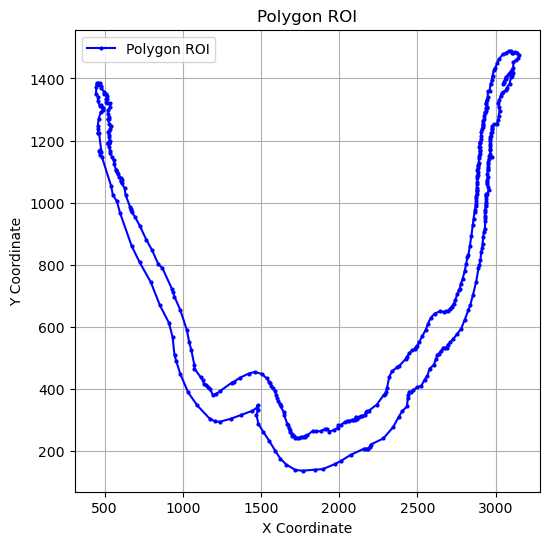

In [22]:
# Read the ROI coordinates from the CSV file
polygon_coords = pd.read_csv(ROI_filepath)

# Extract the X and Y coordinates
x_coords = polygon_coords['X']
y_coords = polygon_coords['Y']


# Create a plot
plt.figure(figsize=(6, 6))
plt.plot(x_coords, y_coords, marker='o', linestyle='-', color='b', label='Polygon ROI', markersize=2)

# Close the polygon by connecting the last point to the first
plt.plot([x_coords.iloc[0], x_coords.iloc[-1]], [y_coords.iloc[0], y_coords.iloc[-1]], 'b-')

# Adding labels and title
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title("Polygon ROI")
plt.legend()
plt.grid(True)

In [23]:
level = 0
pixelsize = scalefactors[level]
image_chanel_0 = tifffile.imread(fullres_chanel_0, is_ome=False, level=level)


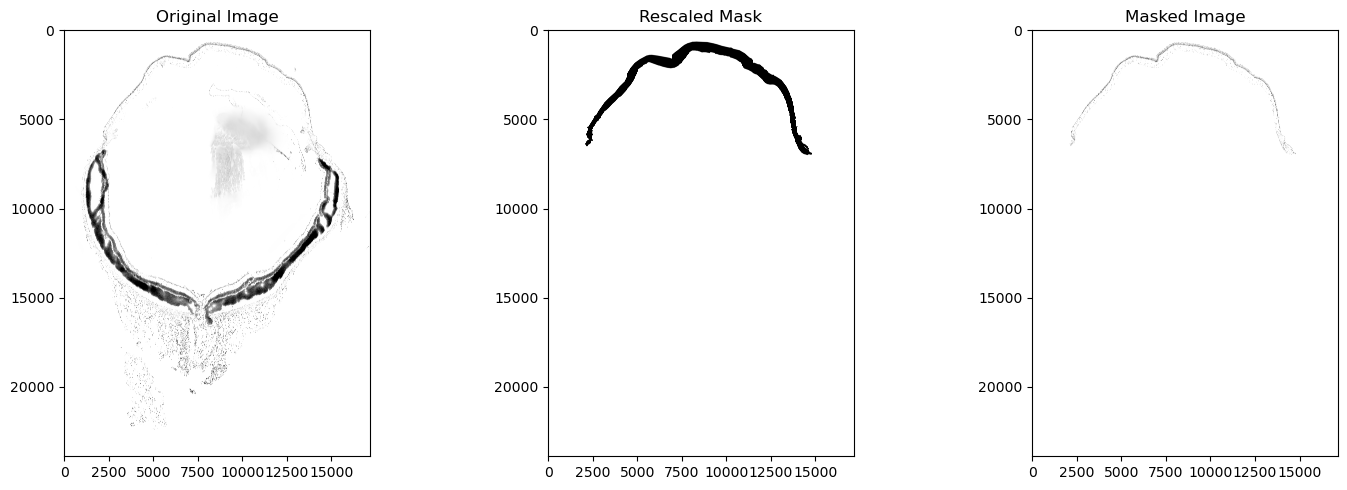

In [24]:
import cv2
import numpy as np

level = 0
pixelsize = scalefactors[level]

# 1. Rescale the coordinates
scaling_factor = pixelsize
x_coords_rescaled = x_coords / scaling_factor
y_coords_rescaled = y_coords / scaling_factor

# 2. Convert rescaled coordinates to points format for fillPoly
points_rescaled = np.column_stack((x_coords_rescaled, y_coords_rescaled)).astype(np.int32)
points_rescaled = points_rescaled.reshape((-1, 1, 2))

# 3. Create mask matching image shape
mask = np.zeros(image_chanel_0.shape, dtype=np.uint8)

# 4. Fill the polygon in white (255)
cv2.fillPoly(mask, [points_rescaled], color=255)

# 5. Apply mask to original image
mask_bool = mask > 0
masked_image_0 = np.zeros_like(image_chanel_0)
masked_image_0[mask_bool] = image_chanel_0[mask_bool]

# 6. Visualize to check the results
plt.figure(figsize=(15, 5))

plt.subplot(131)
plt.imshow(image_chanel_0, cmap='binary')
plt.title('Original Image')
plt.axis('scaled')

plt.subplot(132)
plt.imshow(mask, cmap='binary')
plt.title('Rescaled Mask')
plt.axis('scaled')

plt.subplot(133)
plt.imshow(masked_image_0, cmap='binary')
plt.title('Masked Image')
plt.axis('scaled')

plt.tight_layout()
plt.show()

In [25]:
image_chanel_2 = tifffile.imread(fullres_chanel_2, is_ome=False, level=level)


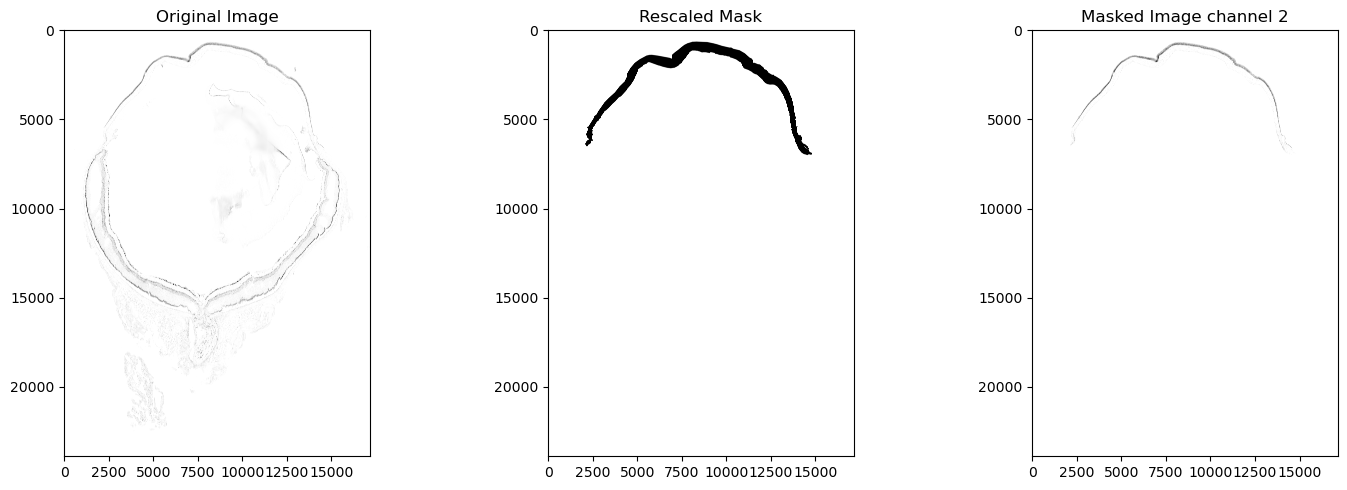

In [26]:
import cv2
import numpy as np

level = 0
pixelsize = scalefactors[level]

# 1. Rescale the coordinates
scaling_factor = pixelsize
x_coords_rescaled = x_coords / scaling_factor
y_coords_rescaled = y_coords / scaling_factor

# 2. Convert rescaled coordinates to points format for fillPoly
points_rescaled = np.column_stack((x_coords_rescaled, y_coords_rescaled)).astype(np.int32)
points_rescaled = points_rescaled.reshape((-1, 1, 2))

# 3. Create mask matching image shape
mask = np.zeros(image_chanel_0.shape, dtype=np.uint8)

# 4. Fill the polygon in white (255)
cv2.fillPoly(mask, [points_rescaled], color=255)

# 5. Apply mask to original image
mask_bool = mask > 0
masked_image_2 = np.zeros_like(image_chanel_2)
masked_image_2[mask_bool] = image_chanel_2[mask_bool]

# 6. Visualize to check the results
plt.figure(figsize=(15, 5))

plt.subplot(131)
plt.imshow(image_chanel_2, cmap='binary')
plt.title('Original Image')
plt.axis('scaled')

plt.subplot(132)
plt.imshow(mask, cmap='binary')
plt.title('Rescaled Mask')
plt.axis('scaled')

plt.subplot(133)
plt.imshow(masked_image_2, cmap='binary')
plt.title('Masked Image channel 2')
plt.axis('scaled')

plt.tight_layout()
plt.show()

In [27]:

def crop_polygon_to_overlapping_squares(polygon, square_size, overlap_size=40/0.2125):
    """
    Crops a polygon into overlapping square regions of a given size.

    Args:
        polygon (Polygon): The input polygon to crop.
        square_size (float): The base size of each square region (side length).
        overlap_size (float): The amount of overlap in um (default: 20).

    Returns:
        List[Polygon]: List of overlapping square polygons that fully contain the polygon.
    """
    # Get bounding box of the polygon
    minx, miny, maxx, maxy = polygon.bounds

    # Generate grid of overlapping squares
    squares = []
    for x in range(int(minx), int(maxx), square_size):
        for y in range(int(miny), int(maxy), square_size):
            # Create expanded square with overlap
            # First vertex (x, y) remains the same
            # Other vertices are expanded by overlap_size
            square = box(
                x,                          # minx (unchanged)
                y,                          # miny (unchanged)
                x + square_size + overlap_size,  # maxx (expanded)
                y + square_size + overlap_size   # maxy (expanded)
            )
            # Check if the square intersects the polygon
            if polygon.intersects(square):
                squares.append(square)
    
    return squares

In [28]:
# Combine X and Y into coordinate pairs
rescaled_polygon_roi = list(zip(x_coords_rescaled, y_coords_rescaled))

# Create a Polygon object
rescaled_polygon_roi = Polygon(rescaled_polygon_roi)
print(rescaled_polygon_roi)

POLYGON ((2161.7561901176473 5766.95952, 2187.4602221176474 5755.237176470589, 2257.609832 5471.734545882353, 2204.155608470588 5498.461656470588, 2176.9239454117646 5490.512592941177, 2211.732583529412 5434.818823529411, 2272.4973567058823 5397.892908235294, 2545.8955887058823 4964.9022070588235, 2601.5893567058824 4825.667656470589, 2723.4195901176467 4724.722555294118, 2821.7538865882357 4544.996123764706, 3169.840267764706 4047.2326254117647, 3410.0199237647057 3800.091215529412, 3744.182796235294 3500.7369143529413, 4016.5604160000003 3151.007205647059, 4288.067767058824 2886.4616089411766, 4397.715030117647 2672.7482263529414, 4456.889741647059 2397.7599322352944, 4509.102698352942 2307.2575265882356, 4627.451988235294 2115.8100169411764, 4864.150832941176 1833.8599684705885, 5139.139129411765 1635.4508376470587, 5517.683068235295 1431.807515764706, 5678.495369411765 1392.2769849411766, 5820.518112941177 1386.5563129411764, 6154.7602447058825 1432.9968475294118, 6470.641934117647

square: POLYGON ((3221.235294117647 3468, 3221.235294117647 4597.235294117647, 2092 4597.235294117647, 2092 3468, 3221.235294117647 3468))
 x: array('d', [3221.235294117647, 3221.235294117647, 2092.0, 2092.0, 3221.235294117647]) 
 y: array('d', [3468.0, 4597.235294117647, 4597.235294117647, 3468.0, 3468.0])
square: POLYGON ((3221.235294117647 4409, 3221.235294117647 5538.235294117647, 2092 5538.235294117647, 2092 4409, 3221.235294117647 4409))
 x: array('d', [3221.235294117647, 3221.235294117647, 2092.0, 2092.0, 3221.235294117647]) 
 y: array('d', [4409.0, 5538.235294117647, 5538.235294117647, 4409.0, 4409.0])
square: POLYGON ((3221.235294117647 5350, 3221.235294117647 6479.235294117647, 2092 6479.235294117647, 2092 5350, 3221.235294117647 5350))
 x: array('d', [3221.235294117647, 3221.235294117647, 2092.0, 2092.0, 3221.235294117647]) 
 y: array('d', [5350.0, 6479.235294117647, 6479.235294117647, 5350.0, 5350.0])
square: POLYGON ((3221.235294117647 6291, 3221.235294117647 7420.23529411

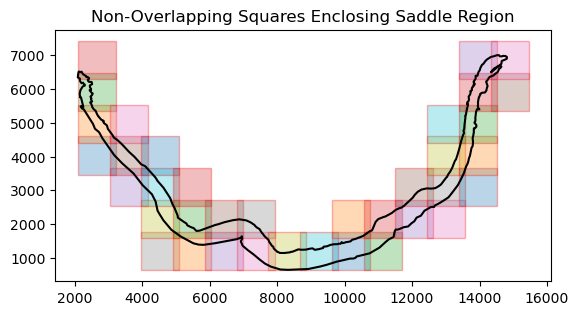

In [29]:
# Define square size
square_size = int(crop_size) # Adjust as necessary 


# Generate non-overlapping square regions
overlapping_squares = crop_polygon_to_overlapping_squares(rescaled_polygon_roi, square_size)

# Visualization
fig, ax = plt.subplots()
# Plot the original polygon
x, y = rescaled_polygon_roi.exterior.xy
ax.plot(x, y, 'k-', label="Saddle-shaped Polygon")  # Black for polygon

# Plot the square regions
for square in overlapping_squares:
    print("square:", square)
    x, y = square.exterior.xy
    print(" x:", x,"\n", "y:", y)
    ax.fill(x, y, edgecolor='red', alpha=0.3, label="Red Square")

# Add labels and legend
ax.set_title(f"Non-Overlapping Squares Enclosing Saddle Region")
ax.set_aspect('equal', 'box')
# ax.legend(loc="upper left")
plt.show()

In [30]:
import os

# Define a function to crop the image based on a shapely Polygon
def crop_region(image, poly):
    """
    Crops the rectangular bounding box of a polygon from an image.

    Parameters:
        image (ndarray): The original image to crop.
        poly (Polygon): A shapely Polygon object defining the region.

    Returns:
        ndarray: The cropped image region.
    """
    # Get the bounding box of the polygon
    min_x, min_y, max_x, max_y = map(int, poly.bounds)
    
    # Crop the image using the bounding box
    cropped_image = image[min_y:max_y, min_x:max_x]
    
    return cropped_image


# Process and plot the square regions
for i, square in enumerate(overlapping_squares):
    print(f"Processing square {i + 1}:", square)
    
    # ch 0 Crop the region 
    cropped_image_sub = crop_region(masked_image_0, square)

    # ch2 Crop the region
    cropped_image_sub2 = crop_region(masked_image_2, square)

    cropped_image_sub_combined = np.stack((cropped_image_sub, cropped_image_sub2), axis=0)


    # Check if the folder exists, if not create it
    save_dir = f"{ddir}/cropped_image/{sample_name}"
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
        print(f"Created directory: {save_dir}")

    # Save the cropped image
    save_path = f"{save_dir}/cropped_square_com_{i + 1}.tif"
    tifffile.imwrite(save_path, cropped_image_sub_combined)
    print(f"Cropped image saved to {save_path}")
    

Processing square 1: POLYGON ((3221.235294117647 3468, 3221.235294117647 4597.235294117647, 2092 4597.235294117647, 2092 3468, 3221.235294117647 3468))
Cropped image saved to G:\Alexis_data\Project\SpatialOmics_cellpose\results/cropped_image/1886od/cropped_square_com_1.tif
Processing square 2: POLYGON ((3221.235294117647 4409, 3221.235294117647 5538.235294117647, 2092 5538.235294117647, 2092 4409, 3221.235294117647 4409))
Cropped image saved to G:\Alexis_data\Project\SpatialOmics_cellpose\results/cropped_image/1886od/cropped_square_com_2.tif
Processing square 3: POLYGON ((3221.235294117647 5350, 3221.235294117647 6479.235294117647, 2092 6479.235294117647, 2092 5350, 3221.235294117647 5350))
Cropped image saved to G:\Alexis_data\Project\SpatialOmics_cellpose\results/cropped_image/1886od/cropped_square_com_3.tif
Processing square 4: POLYGON ((3221.235294117647 6291, 3221.235294117647 7420.235294117647, 2092 7420.235294117647, 2092 6291, 3221.235294117647 6291))
Cropped image saved to G:\